In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn.metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import tensorflow as tf
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
rul_1_gt = pd.read_csv("D:/CMAPSSData/RUL_FD001.txt", header=None)

rul_1_gt.rename(columns={0: "RUL_1gt"}, inplace=True)   

column_name_dict={ 0: "engine_id", 1: "cycle", 2: "op_set_1", 3: "op_set_2", 4: "op_set_3", 5:"sensor_1", 6: "sensor_2",
                   7: "sensor_3", 8: "sensor_4", 9: "sensor_5", 10: "sensor_6", 11: "sensor_7", 12: "sensor_8", 13: "sensor_9",
                  14: "sensor_10", 15: "sensor_11", 16: "sensor_12", 17: "sensor_13", 18: "sensor_14", 19: "sensor_15", 20: "sensor_16",
                  21: "sensor_17", 22: "sensor_18", 23: "sensor_19", 24: "sensor_20", 25: "sensor_21", 26: "sensor_22", 27: "sensor_23"}

################   ################   ################   ################ 

test_1 = pd.read_csv("D:/CMAPSSData/test_FD001.txt", header=None, sep=' ')

test_1.rename(columns=column_name_dict, inplace=True)

################   ################   ################   ################ 

train_1 = pd.read_csv("D:/CMAPSSData/train_FD001.txt", header=None, sep=' ')

train_1.rename(columns=column_name_dict, inplace=True)

In [7]:
# Feture selection
train_1.drop(
    columns=["op_set_1","op_set_2","op_set_3",
             "sensor_1","sensor_5","sensor_6",
             "sensor_10","sensor_16","sensor_18",
             "sensor_19","sensor_22","sensor_23"], inplace=True)


test_1.drop(
    columns=["op_set_1","op_set_2","op_set_3",
             "sensor_1","sensor_5","sensor_6",
             "sensor_10","sensor_16","sensor_18",
             "sensor_19","sensor_22","sensor_23"], inplace=True)

In [8]:
#Compute RUL values -- RUL for train_1 
rul_1 = pd.DataFrame(train_1.groupby('engine_id')['cycle'].max()).reset_index()
rul_1.columns = ['engine_id', 'max']

rul_train_1 = train_1.merge(rul_1, on=['engine_id'], how='left')
rul_train_1['RUL'] = rul_train_1['max'] - rul_train_1['cycle']
rul_train_1.drop(['max'], axis=1, inplace=True)

###############################################
#Compute RUL values -- RUL for test_1 
rul_1_gt["engine_id"]=rul_1_gt.index + 1

max_1 = pd.DataFrame(test_1.groupby('engine_id')['cycle'].max()).reset_index()
max_1.columns = ['engine_id', 'max']
max_test_1 = test_1.merge(max_1, on=['engine_id'], how='left')
rul_test_1 = max_test_1.merge(rul_1_gt, on=['engine_id'], how='left')

rul_test_1['RUL'] = rul_test_1['max'] - rul_test_1['cycle'] + rul_test_1["RUL_1gt"] 
rul_test_1.drop(['max', 'RUL_1gt'], axis=1, inplace=True)

In [9]:
#train_1 minmax scaling
cols_normalize_1 = rul_train_1.columns.difference(['engine_id','cycle'])

scaler_1 = MinMaxScaler()
norm_rul_train_1 = pd.DataFrame(scaler_1.fit_transform(rul_train_1[cols_normalize_1]), 
                                columns=cols_normalize_1, 
                                index=rul_train_1.index)

norm_rul_train_1=pd.concat([norm_rul_train_1, rul_train_1[["engine_id", "cycle"]]], axis=1)

################   ################   ################   ################   ################

#test_1 minmax scaling
norm_rul_test_1 = pd.DataFrame(scaler_1.transform(rul_test_1[cols_normalize_1]), 
                                columns=cols_normalize_1, 
                                index=rul_test_1.index)

norm_rul_test_1=pd.concat([norm_rul_test_1, rul_test_1[["engine_id", "cycle"]]], axis=1)

In [10]:
# we are only interested in the LAST CYCLE of each engine in the test set as we only have True RUL values for those records.
# sort lists by the # of engines
g_train_1=norm_rul_train_1.groupby('engine_id')
g_test_1=norm_rul_test_1.groupby('engine_id')

#list of dfs(engines)
train_list = []
test_list = []  

for engineid in g_train_1.groups.keys():
    train_list.append(g_train_1.get_group(engineid)) 

for engineid in g_test_1.groups.keys():
    test_list.append(g_test_1.get_group(engineid))

In [11]:
len(train_list), len(test_list)

(100, 100)

In [12]:
#generating sequences for each engine --> multivariate one step problem
from numpy import array

#df: df extracted from train_list, n_steps: window size
def split_sequences(df, n_steps):
    X, y = list(), list()
    for i in range(len(df)):
        end_ix = i + n_steps
        if end_ix > len(df):
            break
        seq_x, seq_y = df[i:end_ix, 1:], df[end_ix-1, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


list_x=[]
list_y=[]
for engine_df in train_list:
    #convert df to arr 
    engine_arr=engine_df.drop(columns=["engine_id", "cycle"]).to_numpy()
    X, y = split_sequences(engine_arr, 21)#since smallest df has 21 rows
    list_x.append(X)
    list_y.append(y)

#concat alt alta  
X_arr=np.concatenate(list_x)
y_arr=np.concatenate(list_y)

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X_arr, y_arr, test_size=0.1, random_state=32
)

In [14]:
X_arr.shape

(18631, 21, 14)

In [15]:
y_arr.shape

(18631,)

In [16]:
x_train.shape

(16767, 21, 14)

In [17]:
y_train.shape

(16767,)

In [18]:
x_test.shape

(1864, 21, 14)

In [19]:
y_test.shape

(1864,)

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        """Reshape x to the shape (batch_size, -1, num_heads, embedding dimension.
        Used to obtain the separate attention heads in each for each batch."""
        # -1 to ensure the dimension of the reshaped tensor is compatible with
        # the original x
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        # ensure the transposed tensor dimensions are 0, 2, 1, 3
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        # Recombine the heads
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [21]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            # note: doesnt use GELU as noted in our text
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        # Multi-head attention
        attn_output = self.att(inputs)
        # Apply dropout
        attn_output = self.dropout1(attn_output, training=training)
        # Add and norm
        # NOTE!!! This does not use leaky relu or GELU?
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        # Pass through FFNN, dropout again
        ffn_output = self.dropout2(ffn_output, training=training)
        # Final add and norm
        return self.layernorm2(out1 + ffn_output)

In [22]:
class TransformerBlockWithLeakyRelu(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlockWithLeakyRelu, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            # note: doesnt use GELU as noted in our text
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
        )
        self.leakyrelu = keras.Sequential(
            # note: doesnt use GELU as noted in our text
            [layers.Dense(ff_dim, activation="LeakyReLU"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        # Multi-head attention
        attn_output = self.att(inputs)
        # Apply dropout
        attn_output = self.dropout1(attn_output, training=training)
        # Apply leakyrelu after each sublayer
        attn_output = self.leakyrelu(attn_output)
        # Add and norm
        # NOTE!!! This does not use leaky relu or GELU?
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        # Pass through FFNN, dropout again
        ffn_output = self.dropout2(ffn_output, training=training)
        # Apply leakyrelu
        ffn_output = self.leakyrelu(ffn_output)
        # Final add and norm
        return self.layernorm2(out1 + ffn_output)

In [23]:
class PositionalEmbedding(layers.Layer):
    """Add positional embedding"""
    def __init__(self, maxlen, embed_dim):
        super(PositionalEmbedding, self).__init__()
        self.maxlen = maxlen
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # maxlen = tf.shape(x)[-1]
        maxlen = self.maxlen
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

In [24]:
class LinearLayer(layers.Layer):
    """LinearLayer"""
    def __init__(self, maxlen):
        super(LinearLayer, self).__init__()
        self.linear = layers.Dense(units=maxlen)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.linear(x)
        return x

In [33]:
# 1. Setting the parameters:

seq_len=x_train.shape[1]
num_features=x_train.shape[2]

embed_dim = 512  # Embedding size for each token
num_heads = 4 # 1 - Number of attention heads
ff_dim = 512 # 3 - feed forward network hidden dimension * Hidden layer size in feed forward network inside transformer
droupout_rate = 0.2  # 4 - Droupoutrate

# 2. Constructing the layers:
#inputs = layers.Input(shape=(maxlen,))
inputs = layers.Input(shape=(seq_len, num_features))
print(inputs)
#embedding_layer = LinearLayer(maxlen)
#embedding_layer = LinearLayer(seq_len)

embedding_layer = LinearLayer(embed_dim)
positional_embeddings = PositionalEmbedding(maxlen=seq_len, embed_dim=embed_dim)


# 3. Building the network:
x = embedding_layer(inputs)
#print(x.shape)
x = positional_embeddings(x) # adding positional embeddings
#print(x.shape)
#transformer_block = TransformerBlock(maxlen, num_heads, ff_dim)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, droupout_rate)

# Try to write a for loop for the number of transfor block
# 2 - Number of Transformer_blocks
x = transformer_block(x)
x = transformer_block(x)
x = transformer_block(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(droupout_rate)(x)

# 5 - Activation parameter
x = layers.Dense(20, activation="sigmoid")(x)

x = layers.Dropout(droupout_rate)(x)

#outputs = layers.Dense(2, activation="softmax")(x)# activation should be linear. <<<<<-------TASK
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 14), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
(None, 21, 512)
(None, 21, 512)


In [39]:
# 8 - learning rate - determine the default value
model.compile(optimizer=Adam(lr=0.001), loss='mse')
#model.compile(optimizer=Adam(lr=0.005), loss='mse')
#This callback will stop the training when there is no improvement in the validation loss for 20 consecutive epochs. 
#regularization technique as preventing overfitting, model runtime gets shorter
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)


# 6 - batch_size
# 7 - epochs
history = model.fit(
    x_train, y_train, batch_size=256, epochs=100, validation_data=(x_test, y_test))

C:\Users\noori\.conda\envs\tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
66/66 [==============================] - 15s 186ms/step - loss: 0.1946 - val_loss: 0.0320
Epoch 2/100
66/66 [==============================] - 11s 164ms/step - loss: 0.0633 - val_loss: 0.0319
Epoch 3/100
66/66 [==============================] - 12s 175ms/step - loss: 0.0382 - val_loss: 0.0333
Epoch 4/100
66/66 [==============================] - 12s 182ms/step - loss: 0.0365 - val_loss: 0.0340
Epoch 5/100
66/66 [==============================] - 12s 187ms/step - loss: 0.0355 - val_loss: 0.0363
Epoch 6/100
66/66 [==============================] - 12s 180ms/step - loss: 0.0348 - val_loss: 0.0339
Epoch 7/100
66/66 [==============================] - 12s 189ms/step - loss: 0.0343 - val_loss: 0.0344
Epoch 8/100
66/66 [==============================] - 12s 184ms/step - loss: 0.0341 - val_loss: 0.0326
Epoch 9/100
66/66 [==============================] - 12s 176ms/step - loss: 0.0340 - val_loss: 0.0320
Epoch 10/100
66/66 [==============================] - 12s 180ms/step - loss: 0.035

Text(0.5, 1.0, 'Loss Error')

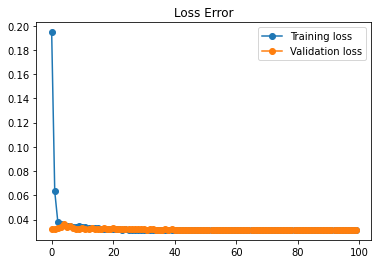

In [40]:
# plotting training loss and validation loss ----- 
plt.plot(history.history['loss'], 'o-',label='Training loss')
plt.plot(history.history['val_loss'], 'o-',label='Validation loss')
plt.legend()
plt.title('Loss Error')

In [41]:
#prepare test set to make predictions
list_x_test=[]
list_y_test=[]

for engine_df in test_list:
    #convert df to arr 
    engine_arr=engine_df.drop(columns=["engine_id", "cycle"]).to_numpy()
    X, y = split_sequences(engine_arr, seq_len)
    
    #use only last seq for each engine
    list_x_test.append(X[-1].reshape((1, seq_len, num_features)))
    list_y_test.append(y[-1].reshape((1, )))

#concat alt alta  
X_arr_test=np.concatenate(list_x_test)
y_arr_test=np.concatenate(list_y_test)

In [42]:
# We have to make inverse scaling for RUL column in order to produce proper prediction results
#create a dummy df to take inverse only on one col --> "y_pred"
def invTransform(scaler, y_pred, colNames):
    dummy = pd.DataFrame(np.zeros((len(y_pred), len(colNames))), columns=colNames)
    dummy["RUL"] = y_pred
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy["RUL"].values

In [43]:
#prediction
y_pred = model.predict(X_arr_test, verbose=0)

#inverse scaling for y_pred values
y_pred_inv=invTransform(scaler_1, y_pred, cols_normalize_1)

y_pred_reshaped=y_pred_inv.reshape((len(y_pred_inv, )))
y_pred_reshaped.shape

(100,)

In [44]:
y_truth=rul_1_gt["RUL_1gt"].values
y_truth.shape

(100,)

In [45]:
y_truth

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20], dtype=int64)

In [46]:
y_pred_reshaped

array([97.47088608, 97.47087532, 97.47086456, 97.47087532, 97.47087532,
       97.47087532, 97.47088608, 97.47087532, 97.47087532, 97.47087532,
       97.47087532, 97.47088608, 97.47087532, 97.47087532, 97.47088608,
       97.47088608, 97.47087532, 97.47087532, 97.47088608, 97.47086456,
       97.47088608, 97.47087532, 97.47088608, 97.47087532, 97.47088608,
       97.47088608, 97.47087532, 97.47087532, 97.47087532, 97.47087532,
       97.47085381, 97.47087532, 97.47087532, 97.47085381, 97.47085381,
       97.47085381, 97.47087532, 97.47086456, 97.47089684, 97.47086456,
       97.47086456, 97.47086456, 97.47087532, 97.47087532, 97.47087532,
       97.47086456, 97.47087532, 97.47087532, 97.47086456, 97.47088608,
       97.47087532, 97.47087532, 97.47087532, 97.47089684, 97.47088608,
       97.47085381, 97.47087532, 97.47086456, 97.47088608, 97.47087532,
       97.47086456, 97.47087532, 97.47086456, 97.47086456, 97.47089684,
       97.47086456, 97.47088608, 97.47085381, 97.47087532, 97.47

In [47]:
#error cal. for paper
def score(y_true, y_pred, a1=10, a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score

In [48]:
score(y_truth,y_pred_reshaped)

14748.593518098767

In [49]:
def score_func(y_true, y_pred):
    score_list = [
                  round(score(y_true,y_pred), 2), 
                  round(mean_absolute_error(y_true,y_pred), 2),
                  round(mean_squared_error(y_true,y_pred),2) ** 0.5,
                  round(r2_score(y_true,y_pred), 2)
                  ]
    
    
    print(f' compatitive score: {score_list[0]}')
    print(f' mean absolute error: {score_list[1]}')
    print(f' root mean squared error: {score_list[2]}')
    print(f' R2 score: {score_list[3]}')
    
    return 0

In [50]:
score_func(y_truth,y_pred_reshaped)

 compatitive score: 14748.59
 mean absolute error: 37.26
 root mean squared error: 46.996914792356314
 R2 score: -0.28


0